In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# EYE FOR BLIND
This notebook will be used to prepare the capstone project 'Eye for Blind'

In [2]:
#Import all the required libraries

import glob
import pandas as pd
import numpy as np
import PIL as pil
import os
# import regex as re

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.utils.vis_utils import plot_model

import tensorflow as tf
from tensorflow import keras
import cv2 

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from collections import Counter
import time
from nltk.translate.bleu_score import SmoothingFunction
from nltk.translate.bleu_score import sentence_bleu

In [3]:
# Setting the batch size and buffer size
batch_size = 512
buffer_size = 4096

Let's read the dataset

## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create a dataframe which summarizes the image, path & captions as a dataframe

4.Create a list which contains all the captions & path

5.Visualise the top 30 occuring words in the captions



In [4]:
#Import the dataset and read the image into a seperate variable

! mkdir ~/.kaggle
! cp /content/drive/MyDrive/Colab_Notebooks/CAPSTONE_PROJECT/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d adityajn105/flickr8k
! unzip /content/flickr8k.zip

# Path to all the images
images='Images'

# Getting a list all the image_paths
all_imgs = glob.glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

Streaming output truncated to the last 5000 lines.
  inflating: Images/2844963839_ff09cdb81f.jpg  
  inflating: Images/2845246160_d0d1bbd6f0.jpg  
  inflating: Images/2845691057_d4ab89d889.jpg  
  inflating: Images/2845845721_d0bc113ff7.jpg  
  inflating: Images/2846037553_1a1de50709.jpg  
  inflating: Images/2846785268_904c5fcf9f.jpg  
  inflating: Images/2846843520_b0e6211478.jpg  
  inflating: Images/2847514745_9a35493023.jpg  
  inflating: Images/2847615962_c330bded6e.jpg  
  inflating: Images/2847859796_4d9cb0d31f.jpg  
  inflating: Images/2848266893_9693c66275.jpg  
  inflating: Images/2848571082_26454cb981.jpg  
  inflating: Images/2848895544_6d06210e9d.jpg  
  inflating: Images/2848977044_446a31d86e.jpg  
  inflating: Images/2849194983_2968c72832.jpg  
  inflating: Images/2850719435_221f15e951.jpg  
  inflating: Images/2851198725_37b6027625.jpg  
  inflating: Images/2851304910_b5721199bc.jpg  
  inflating: Images/2851931813_eaf8ed7be3.jpg  
  inflating: Images/2852982055_8112d0

In [5]:
#Import the dataset and read the text file into a seperate variable

def load_doc(filename):    
    return pd.read_csv(filename)

doc = load_doc('captions.txt')

# Printing the first 300 rows of the dataset
print(doc[:300])

                         image                                            caption
0    1000268201_693b08cb0e.jpg  A child in a pink dress is climbing up a set o...
1    1000268201_693b08cb0e.jpg              A girl going into a wooden building .
2    1000268201_693b08cb0e.jpg   A little girl climbing into a wooden playhouse .
3    1000268201_693b08cb0e.jpg  A little girl climbing the stairs to her playh...
4    1000268201_693b08cb0e.jpg  A little girl in a pink dress going into a woo...
..                         ...                                                ...
295  1077546505_a4f6c4daa9.jpg  A boy in blue shorts slides down a slide into ...
296  1077546505_a4f6c4daa9.jpg  A boy in blue swimming trunks slides down a ye...
297  1077546505_a4f6c4daa9.jpg  A boy rides down a slide into a small backyard...
298  1077546505_a4f6c4daa9.jpg  A boy sliding down a slide into a pool with co...
299  1077546505_a4f6c4daa9.jpg  A child is falling off a slide onto colored ba...

[300 rows x 2 c

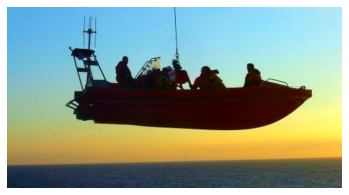



A boat containing people is suspended by a cable .
A boat suspended by a cable over the water .
A raft hanging from a rope over the ocean .
A small group of people are in a small red boat and it is in the air over the ocean .
The boat with passengers gets lifted out of the water by a large cable .


[None, None, None, None, None]

In [6]:
#Visualise both the images & text present in the dataset

plt.imshow(cv2.cvtColor(cv2.imread(all_imgs[0]),cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
print('\n')
cap = list(doc[doc['image']==all_imgs[0][7:]]['caption'])
[print(x) for x in cap]


Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [7]:
all_img_id = doc['image'].apply(lambda x: x[:-4])               # Store all the image id 
all_img_vector = ['Images/'+id+'.jpg' for id in all_img_id]     # Store all the image path 
annotations = doc['caption']                                    # Store all the captions 

df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions']) 
    
df

,ID,Path,Captions
0,1000268201_693b08cb0e,Images/1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e,Images/1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e,Images/1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e,Images/1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e,Images/1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
...,...,...,...
40450,997722733_0cb5439472,Images/997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472,Images/997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,997722733_0cb5439472,Images/997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472,Images/997722733_0cb5439472.jpg,A rock climber in a red shirt .


In [8]:
# Creating a list which contains all the captions
annotations = df['Captions']

# Adding the <start> & <end> token to all those captions as well
annotations = list(annotations.apply(lambda x : ' '.join(['<start>',x,'<end>'])))

# Creating a list which contains all the path to the images
all_img_path = list(set(df['Path']))

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40455
Total images present in the dataset: 8091


In [9]:
#Creating the vocabulary & the counter for the captions

vocabulary = [x.lower() for x in ' '.join(annotations).split()]

val_count=Counter(vocabulary)
val_count

Counter({'<start>': 40455,
         'a': 62986,
         'child': 1545,
         'in': 18974,
         'pink': 735,
         'dress': 348,
         'is': 9345,
         'climbing': 502,
         'up': 1260,
         'set': 108,
         'of': 6713,
         'stairs': 109,
         'an': 2432,
         'entry': 1,
         'way': 50,
         '.': 36577,
         '<end>': 40455,
         'girl': 3328,
         'going': 149,
         'into': 1074,
         'wooden': 284,
         'building': 510,
         'little': 1768,
         'playhouse': 6,
         'the': 18418,
         'to': 3173,
         'her': 1178,
         'cabin': 4,
         'black': 3832,
         'dog': 8136,
         'and': 8851,
         'spotted': 37,
         'are': 3504,
         'fighting': 132,
         'tri-colored': 14,
         'playing': 2008,
         'with': 7765,
         'each': 430,
         'other': 773,
         'on': 10743,
         'road': 388,
         'white': 3940,
         'brown': 2563,
         

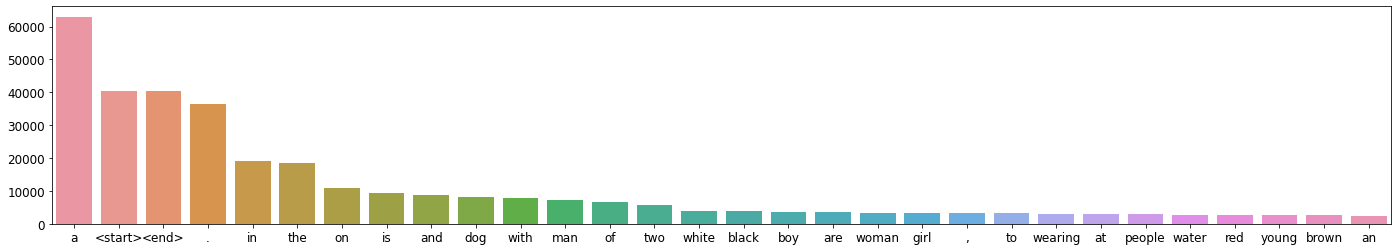

In [10]:
#Visualise the top 30 occuring words in the captions

top_30 = dict(val_count.most_common(30))
plt.figure(figsize=(24,4))
plot = sns.barplot(x=list(top_30.keys()),y=list(top_30.values()))
plot.tick_params(labelsize=12)
plt.show()


## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [11]:
# Creating the tokenizer

tokenizer = Tokenizer(num_words=5000,filters = '!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ',oov_token='<unk>')
tokenizer.fit_on_texts(annotations)
sequences = tokenizer.texts_to_sequences(annotations)

tokenizer.word_index['pad'] = 0
tokenizer.index_word[0] = 'pad'

In [12]:
# Creating word-to-index and index-to-word mapping.

word_to_index = tokenizer.word_index
index_to_word = tokenizer.index_word


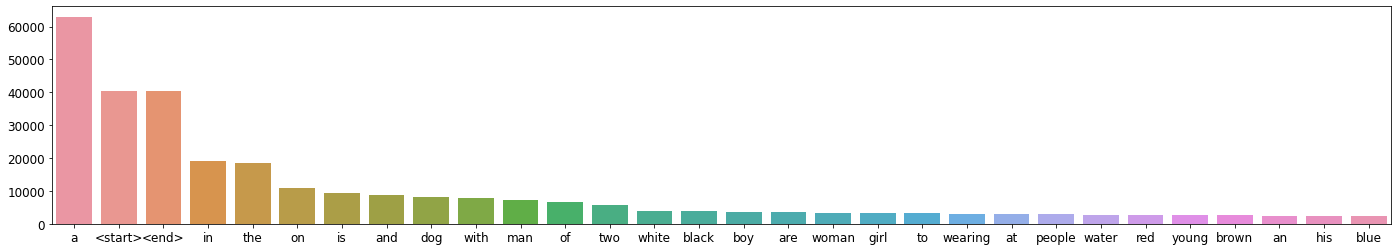

In [13]:
# Creating a word count of your tokenizer to visulizing the Top 30 occuring words after text processing

top_30 = dict(Counter(tokenizer.word_counts).most_common(30))
plt.figure(figsize=(24,4))
plot = sns.barplot(x=list(top_30.keys()),y=list(top_30.values()))
plot.tick_params(labelsize=12)
plt.show()

In [14]:
# Pading each vector to the max_length of the captions and storing it in a vairable

max_len = max([len(x) for x in sequences])
cap_vector= pad_sequences(sequences=sequences,maxlen=max_len,padding='post',value=0)  

print("The shape of Caption vector is :" + str(cap_vector.shape))

The shape of Caption vector is :(40455, 39)


## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

### FAQs on how to resize the images::
* Since you have a list which contains all the image path, you need to first convert them to a dataset using <i>tf.data.Dataset.from_tensor_slices</i>. Once you have created a dataset consisting of image paths, you need to apply a function to the dataset which will apply the necessary preprocessing to each image. 
* This function should resize them and also should do the necessary preprocessing that it is in correct format for InceptionV3.


In [15]:
# Creating the dataset consisting of image paths
dataset = tf.data.Dataset.from_tensor_slices(sorted(set(all_img_path)))

In [16]:
# Creating the function. This function returns images & their path

def load_image(image_path):
    #write your pre-processing steps here
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [17]:
# Applying the function to the image path dataset, such that the transformed dataset should contain images & their path

dataset = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size)

## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of the images using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [18]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

new_input = image_model.input                                                        # Input of the image_model
hidden_layer = image_model.layers[-1].output                                         # Output of the image_model

image_features_extract_model = tf.compat.v1.keras.Model(new_input,hidden_layer)      # Building the final model using both input & output layer

87924736/87910968 [==============================] - 0s 0us/step


In [19]:
# Applying the feature_extraction model to earlier created dataset which contained images & their respective paths
# Once the features are created, reshaping them such that feature shape is in order of (batch_size, 8*8, 2048)

for img, path in tqdm(dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

100%|██████████| 16/16 [01:22<00:00,  5.16s/it]


### FAQs on how to store the features:
* You can store the features using a dictionary with the path as the key and values as the feature extracted by the inception net v3 model OR
* You can store using numpy(np.save) to store the resulting vector.

## Dataset creation
1.Apply train_test_split on both image path & captions to create the train & test list. Create the train-test spliit using 80-20 ratio & random state = 42

2.Create a function which maps the image path to their feature. 

3.Create a builder function to create train & test dataset & apply the function created earlier to transform the dataset

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 8*8, 2048)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [20]:
# Creating Train and Test data
path_train, path_test, cap_train, cap_test = train_test_split(all_img_vector,cap_vector,random_state=42,test_size=0.2,shuffle=True) 

In [21]:
print("Training data for images: " + str(len(path_train)))
print("Testing data for images: " + str(len(path_test)))
print("Training data for Captions: " + str(len(cap_train)))
print("Testing data for Captions: " + str(len(cap_test)))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


In [22]:
# Creating a function which maps the image path to their feature. 
# This function will take the image_path & caption and return it's feature & respective caption.

def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy') 
  return img_tensor, cap

### FAQs on how to load the features:
* You can load the features using the dictionary created earlier OR
* You can store using numpy(np.load) to load the feature vector.

In [23]:
# Creating a builder function to create dataset which takes in the image path & captions as input
# This function transforms the created dataset(img_path,cap) to (features,cap) using the map_func created earlier

def gen_dataset(path,cap):
    # Creating the dataset 
    dataset = tf.data.Dataset.from_tensor_slices((path,cap))
    
    # Useing map to load the numpy files in parallel
    dataset = dataset.map(lambda item1, item2: tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.int32]),num_parallel_calls=tf.data.AUTOTUNE)
    
    # Shuffling and creating batch
    dataset = dataset.shuffle(buffer_size).batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset



In [24]:
train_dataset=gen_dataset(path_train,cap_train)
test_dataset=gen_dataset(path_test,cap_test)

In [25]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,max_len)

(512, 64, 2048)
(512, 39)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [26]:
# setting some basic parameters

embedding_dim = 256 
units = 512
vocab_size = 5000+1 
attention_features_shape = 64
train_num_steps = len(path_train) // batch_size
test_num_steps = len(path_test) // batch_size

### Encoder

In [27]:
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embedding_dim)  # Building a Dense layer
        
    def call(self, features):
        features = tf.nn.relu(self.dense(features))        # Applying relu activation to extract the features from the image, 
        return features                                    # shape: (batch, 8*8, embed_dim)        

    def model(self):
        x = keras.Input(shape=(64,2048))
        return Model(inputs=[x],outputs=self.call(x)) 

In [28]:
encoder=Encoder(embedding_dim)

In [29]:
encoder.model().summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 2048)]        0         
                                                                 
 dense (Dense)               (None, 64, 256)           524544    
                                                                 
 tf.nn.relu (TFOpLambda)     (None, 64, 256)           0         
                                                                 
Total params: 524,544
Trainable params: 524,544
Non-trainable params: 0
_________________________________________________________________


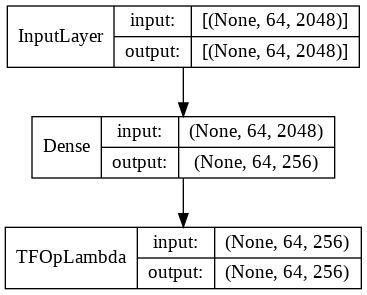

In [30]:
plot_model(encoder.model(), to_file='encoder.png', show_shapes=True, show_layer_names=False)

### Attention model

In [31]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
        self.units=units

    def call(self, features, hidden):
        # features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)                                           # Expanding the hidden shape to shape: (batch_size, 1, hidden_size)
        attention_hidden_layer = (tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis)))
        score = self.V(attention_hidden_layer)                                                      # Building score funciton to shape: (batch_size, 8*8, units)
        attention_weights = tf.nn.softmax(score, axis=1)                                            # Extracting attention weights with shape: (batch_size, 8*8, 1)
        context_vector = attention_weights * features                                               # Creating the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis=1)                                      # Reducing the shape to (batch_size, embedding_dim)

        return context_vector, attention_weights

    def model(self):
        x = keras.Input(shape=(64,256))
        y = keras.Input(shape=(512))
        return Model(inputs=(x,y),outputs=self.call(x,y))


In [32]:
attention = Attention_model(1)

attention.model().summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 64, 256)]    0           []                               
                                                                                                  
 tf.expand_dims (TFOpLambda)    (None, 1, 512)       0           ['input_5[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 64, 1)        257         ['input_4[0][0]']                
                                                                                            

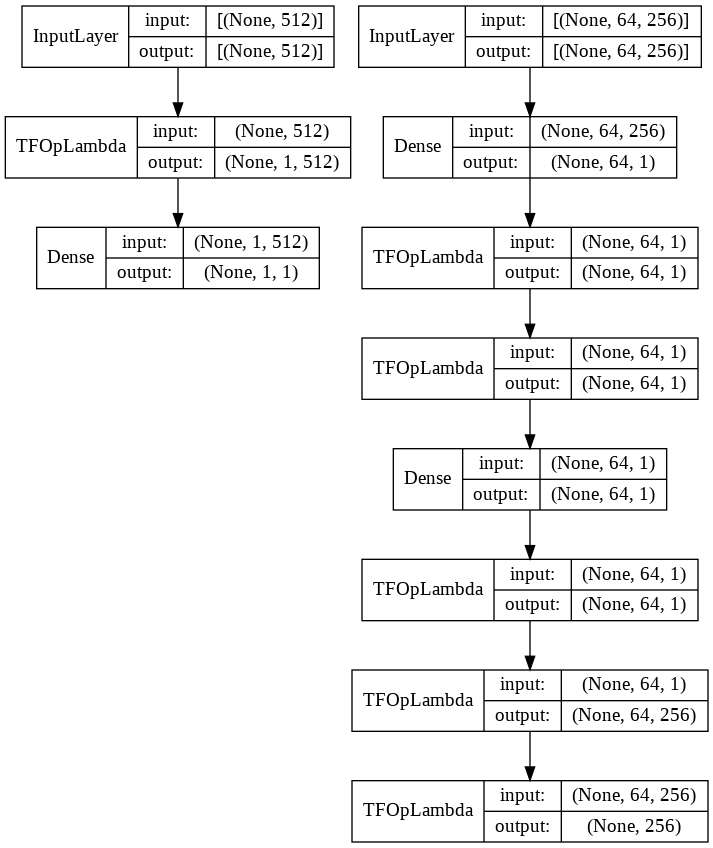

In [33]:
plot_model(attention.model(), to_file='attention.png', show_shapes=True, show_layer_names=False)

### Decoder

In [34]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units)                                                   # Iniitalising the Attention model with units
        self.embed = tf.keras.layers.Embedding(vocab_size, embedding_dim)                              # Building the Embedding layer
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,
                                       return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units)                                                    # Build the Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size)                                                    # Build the final Dense layer 
        

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)      # Creating context vector & attention weights from attention model

        embed =  self.embed(x)                                                    # Embeding input to shape: (batch_size, 1, embedding_dim)

        embed =  tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1)   # Concatenating input with the context vector from attention layer,
                                                                                  # Shape: (batch_size, 1, embedding_dim + embedding_dim)

        output,state = self.gru(embed)                                            # Extracting the output & hidden state from GRU layer,
                                                                                  # Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2]))                        # Shape : (batch_size * max_length, hidden_size)
        output = self.d2(output)                                                  # Shape : (batch_size * max_length, vocab_size)
        
        return output,state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))
    
    def model(self):
        x = keras.Input(shape=(1))
        y = keras.Input(shape=(64,256))
        z = keras.Input(shape=(512))
        return Model(inputs=(x,y,z),outputs=self.call(x,y,z))

In [35]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [36]:
decoder.model().summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 64, 256)]    0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 512)]        0           []                               
                                                                                                  
 attention_model_1 (Attention_m  ((None, 256),       394753      ['input_9[0][0]',                
 odel)                           (None, 64, 1))                   'input_10[0][0]']               
                                                                                                  
 input_8 (InputLayer)           [(None, 1)]          0           []                         

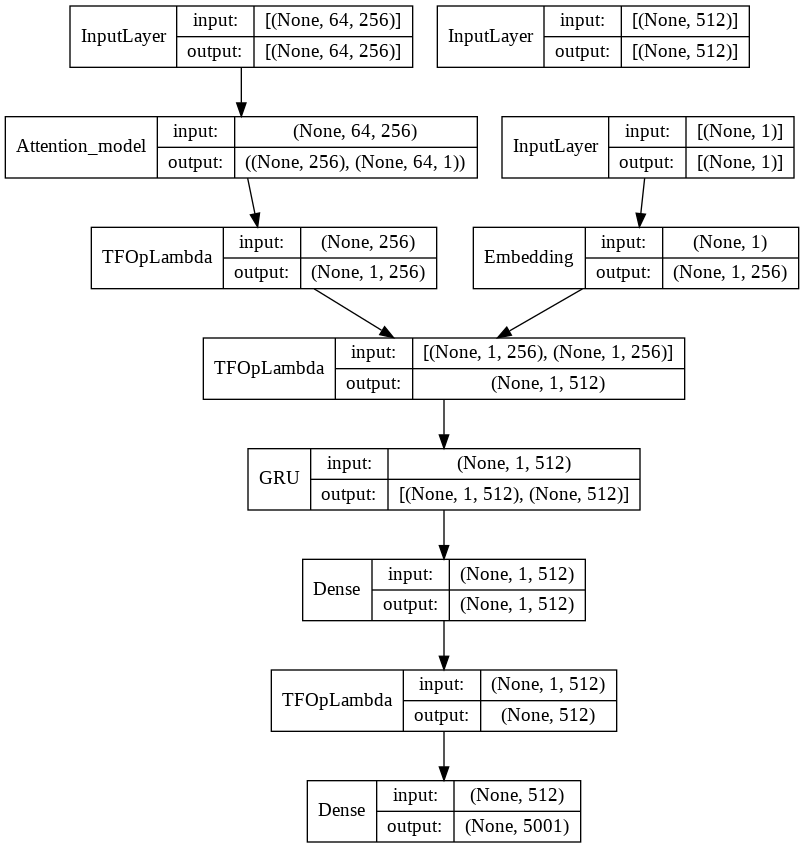

In [37]:
plot_model(decoder.model(), to_file='decoder.png', show_shapes=True, show_layer_names=False)

In [38]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape))                     # Expected Shape : (batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape))              # Expected Shape : (batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape))  # Expected Shape : (batch, 8*8, embed_dim)

Feature shape from Encoder: (512, 64, 256)
Predcitions shape from Decoder: (512, 5001)
Attention weights shape from Decoder: (512, 64, 1)


## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [39]:
# Defining the optimizer
optimizer = tf.keras.optimizers.Adam()

# Defining the loss object
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,reduction='none')

In [40]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [41]:
# Initialising the checkpoint and checkpoint manager
os.mkdir('checkpoint')
checkpoint_path = "/content/checkpoint"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [42]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

* While creating the training step for your model, you will apply Teacher forcing.
* Teacher forcing is a technique where the target/real word is passed as the next input to the decoder instead of previous prediciton.

In [43]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss


* While creating the test step for your model, you will pass your previous prediciton as the next input to the decoder.

In [44]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    encoder_output = encoder(img_tensor)

    for words in range(1,target.shape[1]):
      predictions,hidden,_ = decoder(dec_input,encoder_output,hidden)
      loss += loss_function(target[:,words],predictions)
      predicted_id = tf.argmax(predictions[0])
      dec_input = tf.expand_dims([predicted_id] * target.shape[0] , 1)

    avg_loss = (loss/int(target.shape[1]))
        
    return loss, avg_loss

In [45]:
def test_loss_cal(test_dataset):
    total_loss = 0

    for (batch,(img_tensor,target)) in enumerate(test_dataset):
      batch_loss,loss = test_step(img_tensor,target)
      total_loss += loss 
    
    avg_test_loss = total_loss/int(target.shape[1])
    
    return avg_test_loss

In [46]:
loss_plot = []
test_loss_plot = []
EPOCHS = 15

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  7%|▋         | 1/15 [02:19<32:31, 139.39s/it]

For epoch: 1, the train loss is 1.669, & test loss is 0.718
Time taken for 1 epoch 139.2280559539795 sec

Test loss has been reduced from 100.000 to 0.718


 13%|█▎        | 2/15 [03:00<17:40, 81.57s/it] 

For epoch: 2, the train loss is 1.397, & test loss is 0.838
Time taken for 1 epoch 41.09935641288757 sec



 20%|██        | 3/15 [03:41<12:36, 63.05s/it]

For epoch: 3, the train loss is 1.213, & test loss is 0.812
Time taken for 1 epoch 41.012287616729736 sec



 27%|██▋       | 4/15 [04:22<09:57, 54.34s/it]

For epoch: 4, the train loss is 1.102, & test loss is 0.810
Time taken for 1 epoch 40.98978853225708 sec



 33%|███▎      | 5/15 [05:03<08:15, 49.54s/it]

For epoch: 5, the train loss is 1.035, & test loss is 0.786
Time taken for 1 epoch 41.023789167404175 sec



 40%|████      | 6/15 [05:44<06:59, 46.65s/it]

For epoch: 6, the train loss is 0.983, & test loss is 0.807
Time taken for 1 epoch 41.0411262512207 sec



 47%|████▋     | 7/15 [06:25<05:58, 44.86s/it]

For epoch: 7, the train loss is 0.941, & test loss is 0.828
Time taken for 1 epoch 41.173975467681885 sec



 53%|█████▎    | 8/15 [07:06<05:05, 43.66s/it]

For epoch: 8, the train loss is 0.906, & test loss is 0.784
Time taken for 1 epoch 41.08392786979675 sec



 60%|██████    | 9/15 [07:47<04:16, 42.81s/it]

For epoch: 9, the train loss is 0.875, & test loss is 0.799
Time taken for 1 epoch 40.94966721534729 sec



 67%|██████▋   | 10/15 [08:28<03:31, 42.27s/it]

For epoch: 10, the train loss is 0.846, & test loss is 0.844
Time taken for 1 epoch 41.04138255119324 sec



 73%|███████▎  | 11/15 [09:09<02:47, 41.88s/it]

For epoch: 11, the train loss is 0.821, & test loss is 0.823
Time taken for 1 epoch 41.002010345458984 sec



 80%|████████  | 12/15 [09:50<02:04, 41.62s/it]

For epoch: 12, the train loss is 0.796, & test loss is 0.793
Time taken for 1 epoch 41.00900745391846 sec



 87%|████████▋ | 13/15 [10:31<01:22, 41.42s/it]

For epoch: 13, the train loss is 0.772, & test loss is 0.821
Time taken for 1 epoch 40.95134210586548 sec



 93%|█████████▎| 14/15 [11:12<00:41, 41.32s/it]

For epoch: 14, the train loss is 0.753, & test loss is 0.798
Time taken for 1 epoch 41.09836673736572 sec



100%|██████████| 15/15 [11:53<00:00, 47.59s/it]

For epoch: 15, the train loss is 0.731, & test loss is 0.795
Time taken for 1 epoch 40.883333683013916 sec



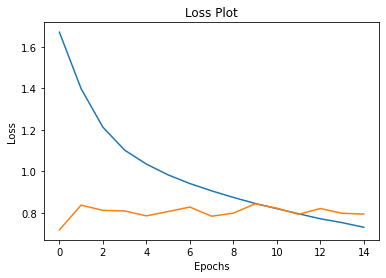

In [47]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

#### NOTE: 
* Since there is a difference between the train & test steps ( Presence of teacher forcing), we may observe that the train loss is decreasing while our test loss is not. 
* This doesn't mean that the model is overfitting, as we can't compare the train & test results here, as both approach are different.
* Also, if we want to achieve better results we can run it for more epochs, but the intent of this capstone is to give an idea on how to integrate attention mechanism with E-D architecture for images. The intent is not to create the state of art model. 

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [48]:
def evaluate(image):
    attention_plot = np.zeros((max_len, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input)# Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val) # extract the features by passing the input to encoder

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_len):
        predictions, hidden, attention_weights =  decoder(dec_input,features,hidden) # get the output from decoder

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy() #extract the predicted id(embedded value) which carries the max value
        predicted_word = tf.compat.as_text(index_to_word[predicted_id]) #map the id to the word from tokenizer and append the value to the result list
        result.append(predicted_word)

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions


In [49]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(pil.Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(pil.Image.fromarray(weights_img).resize((224, 224), pil.Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [50]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

BELU score: 8.664723710180478
Real Caption: a brown dog walking on a snowy surface near snow covered trees
Prediction Caption: two golden colored dog walking down the snow


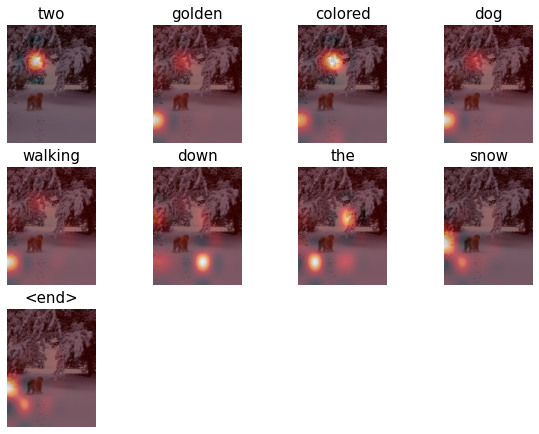

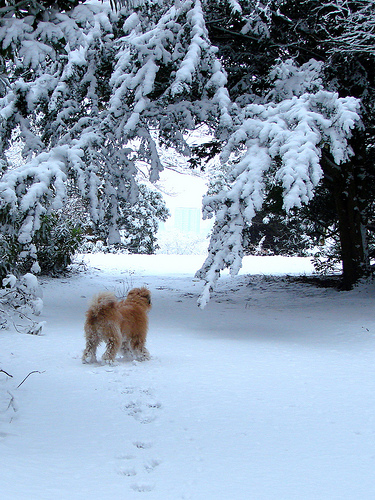

In [65]:
rid = np.random.randint(0, len(path_test))
test_image = path_test[rid]
#test_image = './images/413231421_43833a11f5.jpg'
#real_caption = '<start> black dog is digging in the snow <end>'

real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)


real_caption=filt_text(real_caption)      


pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights=(0,0,1,0),smoothing_function=SmoothingFunction().method2)
print(f"BELU score: {score*100}")

print('Real Caption:', real_caption)
print('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)


pil.Image.open(test_image)